# Importing dependencies

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Data Loading

## Download and normalize to range [-1, 1]

In [0]:
dataset_train = torchvision.datasets.FashionMNIST('./train', train=True, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

In [0]:
dataset_test = torchvision.datasets.FashionMNIST('./test', train=False, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

In [0]:
# Change labels of dataset to real
dataset_train.targets = torch.ones(len(dataset_train))
dataset_test.targets = torch.ones(len(dataset_test))

In [0]:
labels_map = {0: 'Fake', 1: 'Real'}

## Concatenating train and test dataset

In [0]:
dataset = dataset_train + dataset_test
print(f'Length of complete dataset : {len(dataset)}')

Length of complete dataset : 70000


## Initializing constants

In [0]:
torch.cuda.is_available()

True

In [0]:
epochs = 20
output_after_every_n = 1
image_size = 28
input_size = 100
batch_size = 64
num_channels = 1

In [0]:
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Convert into DataLoader

In [0]:
datasetloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [0]:
# This is just for visualization and a little debugging
dataiter = iter(datasetloader)

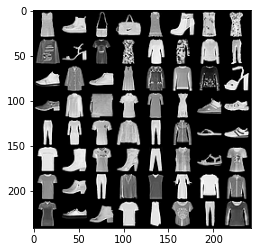

In [0]:
images, labels = dataiter.next()
show_grid(torchvision.utils.make_grid(images, normalize=True))

# Initialize Weights

In [0]:
def initialize_weights(model):
  className = model.__class__.__name__
  if className.find('Conv') != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02)
  elif className.find('BatchNorm') != -1:
    nn.init.normal_(model.weight.data, 1.0, 0.02)
    nn.init.constant_(model.bias.data, 0)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [0]:
class Generator(nn.Module):
  '''
  The Generator Network
  '''

  def __init__(self):
    super(Generator, self).__init__()

    self.conv_trans_1 = nn.Sequential(
        nn.ConvTranspose2d(input_size, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
    )
    # Shape [2 x 2]

    self.conv_trans_2 = nn.Sequential(
        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True)
    )
    # Shape [4 x 4]

    self.conv_trans_3 = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )
    # Shape [7 x 7]

    self.conv_trans_4 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    )
    # Shape [14 x 14]

    self.output_layer = nn.Sequential(
        nn.ConvTranspose2d(64, num_channels, 4, 2, 1, bias=False),
        nn.Tanh()
    )
    # Shape [28 x 28]

    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

  def forward(self, inputs):
    x = self.conv_trans_1(inputs)
    x = self.conv_trans_2(x)
    x = self.conv_trans_3(x)
    x = self.conv_trans_4(x)
    return self.output_layer(x)

In [0]:
generator = Generator()
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (conv_trans_1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_trans_2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_trans_3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_trans_4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (outp

## Test output shape of Generator

torch.Size([64, 1, 28, 28])


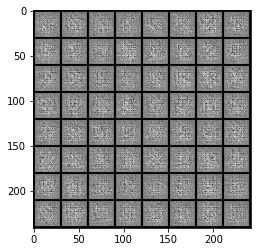

In [0]:
with torch.no_grad():
  # Note: model still in training mode
  noise = torch.randn(size=(batch_size, input_size, 1, 1)).cuda()
  output = generator(noise).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))

# Discriminator Network

Hout = ( (Hin + 2 × padding[0] − dilation[0] × (kernel_size[0] − 1) - 1) / stride[0]) + 1

Wout = ( (Win + 2 × padding[1] − dilation[1] × (kernel_size[1] − 1) - 1) / stride[1]) + 1


In [0]:
class Discriminator(nn.Module):
  '''
  The Discriminator Network
  '''

  def __init__(self):
    super(Discriminator, self).__init__()

    self.conv_1 = nn.Sequential(
        nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True)
    )
    # Shape [14 x 14]

    self.conv_2 = nn.Sequential(
        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True)
    )
    # Shape [7 x 7]

    self.conv_3 = nn.Sequential(
        nn.Conv2d(128, 256, 4, 1, 0, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
    )
    # Shape [4 x 4]

    self.conv_4 = nn.Sequential(
        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True)
    )
    # Shape [2 x 2]

    self.output_layer = nn.Sequential(
        nn.Conv2d(512, 1, 4, 2, 1, bias=False),
        nn.Sigmoid()
    )

    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

  def forward(self, inputs):
    x = self.conv_1(inputs)
    x = self.conv_2(x)
    x = self.conv_3(x)
    x = self.conv_4(x)
    return self.output_layer(x)

In [0]:
discriminator = Discriminator()
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (conv_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(nega

# Specifying Loss Function

In [0]:
adversarial_loss = nn.BCELoss()

# Plotting output after each epoch

In [0]:
def plot_output():
  plt.clf()
  with torch.no_grad():
    input_noise = torch.randn(size=(batch_size, input_size, 1, 1)).cuda()
    
    generator.eval()
    test_images = generator(input_noise)
    generator.train()
  
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
  show_grid(grid)
  return grid

# Training DCGAN

Epoch: 1 / 20
Discriminator Total Loss: 0.298, Generator Total Loss: 3.711


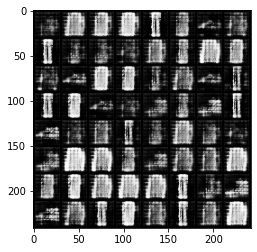

Epoch: 2 / 20
Discriminator Total Loss: 0.349, Generator Total Loss: 3.247


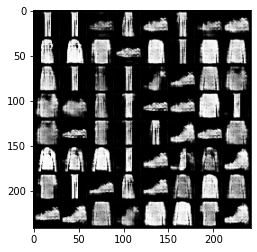

Epoch: 3 / 20
Discriminator Total Loss: 0.475, Generator Total Loss: 2.762


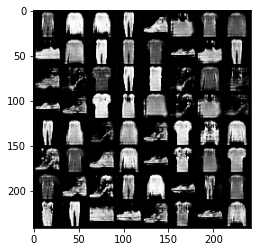

Epoch: 4 / 20
Discriminator Total Loss: 0.536, Generator Total Loss: 2.522


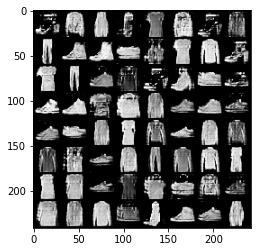

Epoch: 5 / 20
Discriminator Total Loss: 0.543, Generator Total Loss: 2.448


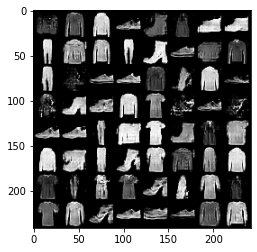

Epoch: 6 / 20
Discriminator Total Loss: 0.522, Generator Total Loss: 2.472


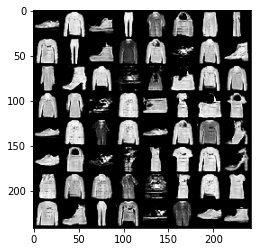

Epoch: 7 / 20
Discriminator Total Loss: 0.498, Generator Total Loss: 2.553


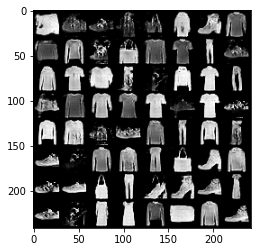

Epoch: 8 / 20
Discriminator Total Loss: 0.497, Generator Total Loss: 2.583


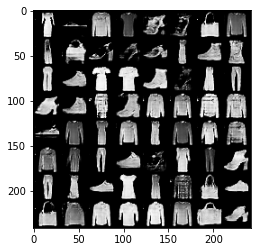

Epoch: 9 / 20
Discriminator Total Loss: 0.491, Generator Total Loss: 2.636


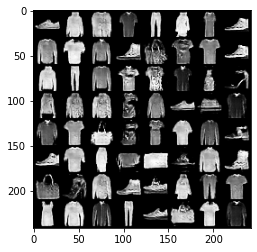

Epoch: 10 / 20
Discriminator Total Loss: 0.463, Generator Total Loss: 2.696


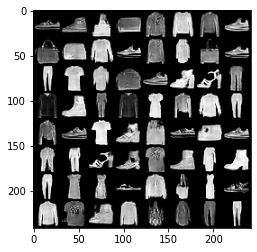

Epoch: 11 / 20
Discriminator Total Loss: 0.459, Generator Total Loss: 2.806


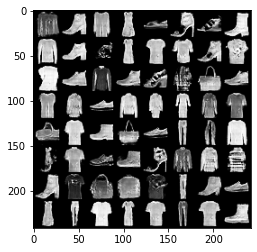

Epoch: 12 / 20
Discriminator Total Loss: 0.429, Generator Total Loss: 2.893


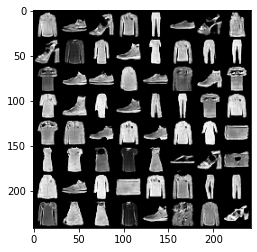

Epoch: 13 / 20
Discriminator Total Loss: 0.400, Generator Total Loss: 2.960


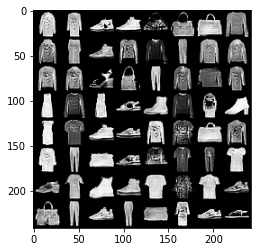

Epoch: 14 / 20
Discriminator Total Loss: 0.396, Generator Total Loss: 3.118


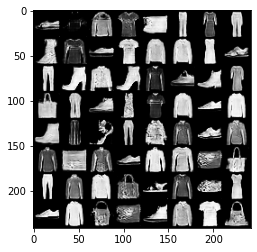

Epoch: 15 / 20
Discriminator Total Loss: 0.361, Generator Total Loss: 3.175


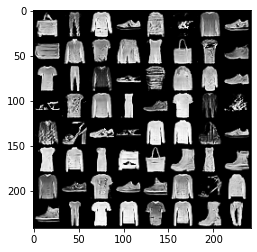

Epoch: 16 / 20
Discriminator Total Loss: 0.389, Generator Total Loss: 3.146


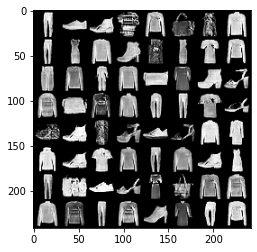

Epoch: 17 / 20
Discriminator Total Loss: 0.378, Generator Total Loss: 3.209


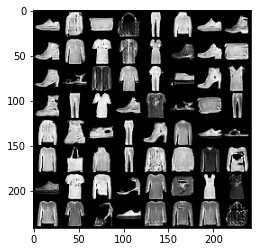

Epoch: 18 / 20
Discriminator Total Loss: 0.375, Generator Total Loss: 3.335


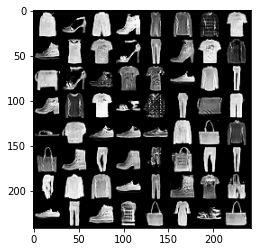

Epoch: 19 / 20
Discriminator Total Loss: 0.333, Generator Total Loss: 3.405


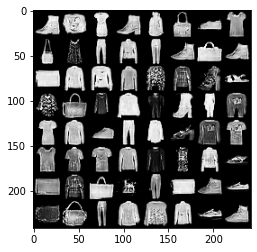

Epoch: 20 / 20
Discriminator Total Loss: 0.351, Generator Total Loss: 3.409


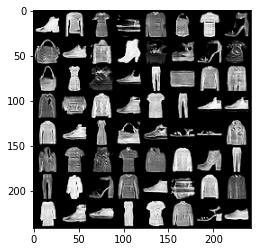

In [0]:
# Set tdqm for epoch progress
pbar = tqdm()
images = []

for epoch in range(epochs):
  print(f'Epoch: {epoch + 1} / {epochs}')
  pbar.reset(total=len(datasetloader))

  # Setting up losses
  discriminator_total_losses = []
  generator_total_losses = []

  for real_images, real_labels in datasetloader:

    # Current batch size
    current_batch_size = real_images.size()[0]

    # Convert to cuda
    real_images = real_images.cuda()
    real_labels = real_labels.type('torch.FloatTensor').cuda() # Already converted to ones earlier
    fake_labels = torch.zeros(current_batch_size, dtype=torch.float).cuda()

    # Training Generator
    generator.zero_grad()

    ## Generate fake images
    input_noise = torch.randn(size=(current_batch_size, input_size, 1, 1)).cuda()
    fake_images = generator(input_noise)

    ## Calculate Generator loss
    discriminator_fake_labels = discriminator(fake_images)
    
    generator_total_loss = adversarial_loss(discriminator_fake_labels.squeeze(), real_labels)
    generator_total_loss.backward()
    generator.optimizer.step()
    generator_total_losses.append(generator_total_loss)

    # Training Discriminator
    discriminator.zero_grad()

    ## Loss for real images
    discriminator_real_labels = discriminator(real_images)
    discriminator_real_loss = adversarial_loss(discriminator_real_labels.squeeze(), real_labels)

    ## Loss for fake images
    discriminator_fake_labels = discriminator(fake_images.detach())
    discriminator_fake_loss = adversarial_loss(discriminator_fake_labels.squeeze(), fake_labels)

    ## Total loss
    discriminator_total_loss = discriminator_real_loss + discriminator_fake_loss
    discriminator_total_loss.backward()
    discriminator.optimizer.step()
    discriminator_total_losses.append(discriminator_total_loss)

    # Update tqdm
    pbar.update()

  print('Discriminator Total Loss: {:.3f}, Generator Total Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_total_losses)),
          torch.mean(torch.FloatTensor(generator_total_losses))
        ))


  if (epoch + 1) % output_after_every_n == 0:
    grid = plot_output()
    images.append(transforms.ToPILImage()(grid))

pbar.refresh()
# Save gif of output
images[0].save('fashionmnist-dcgan.gif', save_all=True, append_images=images[1:])